In [2]:
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
import click
from rra_tools import jobmon
from pymer4.models.Lmer import Lmer

from spatial_temp_cgf import cli_options as clio
from spatial_temp_cgf import binning, scaling
from spatial_temp_cgf.data import DEFAULT_ROOT, ClimateMalnutritionData
from spatial_temp_cgf.model_specification import (
    ModelSpecification,
)

from spatial_temp_cgf.training.run_training import prepare_model_data

In [231]:
def prepare_model_version(model_specification_path):
    output_root = DEFAULT_ROOT

    # Build version and save spec
    model_spec = ModelSpecification.from_yaml(model_specification_path)
    measure = model_spec.measure
    measure_root = Path(output_root) / measure
    cm_data = ClimateMalnutritionData(measure_root)
    model_version = cm_data.new_model_version()
    model_spec.version.model = model_version
    cm_data.save_model_specification(model_spec, model_version)
    return model_version

# Prepare a test version.  Only need to run once to do testing
model_spec_path = "../specifications/stunting_test.yaml"
prepare_model_version(model_spec_path)

'2024_07_01.01'

In [237]:
output_root = Path(DEFAULT_ROOT)
measure = 'stunting'
model_version = '2024_07_01.04'
age_group_id = 5
sex_id = 1

In [238]:
cm_data = ClimateMalnutritionData(output_root / measure)
model_spec = cm_data.load_model_specification(model_version)

# Load training data
full_training_data = cm_data.load_training_data(model_spec.version.training_data)
# FIXME: Prep leaves a bad index
full_training_data = full_training_data.reset_index(drop=True)    
full_training_data['intercept'] = 1.

subset_mask = (
    (full_training_data.sex_id == sex_id) 
    & (full_training_data.age_group_id == age_group_id)
)

raw_df = full_training_data.loc[:, model_spec.raw_variables]   
null_mask = raw_df.isnull().any(axis=1)
assert null_mask.sum() == 0



In [241]:
df, var_info = prepare_model_data(raw_df, model_spec)

In [242]:
var_info

{'intercept': {},
 'mean_temperature': {'bin_edges': array([-10.31,  17.44,  20.38,  21.99,  23.59,  24.73,  25.42,  25.97,
          26.68,  27.68,  31.22]),
  'bins_categorical':    mean_temperature_bin
  0       [-10.31, 17.44)
  1        [17.44, 20.38)
  2        [20.38, 21.99)
  3        [21.99, 23.59)
  4        [23.59, 24.73)
  5        [24.73, 25.42)
  6        [25.42, 25.97)
  7        [25.97, 26.68)
  8        [26.68, 27.68)
  9        [27.68, 31.22)
  10                  NaN,
  'bins':    mean_temperature_bin
  0       [-10.31, 17.44)
  1        [17.44, 20.38)
  2        [20.38, 21.99)
  3        [21.99, 23.59)
  4        [23.59, 24.73)
  5        [24.73, 25.42)
  6        [25.42, 25.97)
  7        [25.97, 26.68)
  8        [26.68, 27.68)
  9        [27.68, 31.22)
  10                  nan},
 'ldi_pc_pd': {'feature_range': (0.00021000055729025876, 179.61527230987207)}}

In [ ]:


raw_df = raw_df.loc[subset_mask].reset_index(drop=True)
df = df.loc[subset_mask].reset_index(drop=True)

In [203]:
# TODO: Test/train split
print(f"Training {model_spec.lmer_formula} for {measure} {model_version} age {age_group_id} sex{sex_id} cols {df.columns}")
model = Lmer(model_spec.lmer_formula, data=df, family='binomial')
model.fit()
if len(model.warnings) > 0:
    # TODO save these to a file
    print(model.warnings)
    raise ValueError(f"Model {model_spec} did not fit.")


Training stunting ~ (1 | ihme_loc_id) + mean_temperature + ldi_pc_pd + mean_temperature * ldi_pc_pd for stunting 2024_06_30.08 age 5 sex1 cols Index(['intercept', 'mean_temperature', 'ldi_pc_pd', 'ihme_loc_id',
       'stunting'],
      dtype='object')
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: stunting~(1|ihme_loc_id)+mean_temperature+ldi_pc_pd+mean_temperature*ldi_pc_pd

Family: binomial	 Inference: parametric

Number of observations: 391086	 Groups: {'ihme_loc_id': 54.0}

Log-likelihood: -250968.982 	 AIC: 501947.963

Random effects:

                    Name    Var    Std
ihme_loc_id  (Intercept)  0.272  0.522

No random effect correlations specified

Fixed effects:



In [210]:
import pickle
from pathlib import Path

p = Path('/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/zzz_archive/v1/models/tempgrid_o30/model_stunting_5_1.pkl')
with p.open('rb') as f:
    m = pickle.load(f)

df = m.data

In [150]:
x = raw_df[raw_df.mean_temperature > 28]
x['ldi_bin'] = pd.qcut(x.ldi_pc_pd, 10)
x.groupby('ldi_bin').stunting.mean()

/tmp/ipykernel_1932042/3330886219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['ldi_bin'] = pd.qcut(x.ldi_pc_pd, 10)


ldi_bin
(0.0033499999999999997, 0.692]    0.229898
(0.692, 1.099]                    0.227633
(1.099, 1.456]                    0.198044
(1.456, 1.826]                    0.187935
(1.826, 2.255]                    0.198606
(2.255, 2.739]                    0.197445
(2.739, 3.308]                    0.196056
(3.308, 4.316]                    0.203016
(4.316, 6.853]                    0.187209
(6.853, 56.063]                   0.145012
Name: stunting, dtype: float64

In [225]:
raw_df[raw_df.ihme_loc_id == 'MLI'].stunting.mean()

0.41944699520457096

In [217]:
r = raw_df.combine_first(model.data)

In [222]:
full_training_data

,nid,ihme_loc_id,year_start,year_end,psu,hh_id,sex_id,age_year,age_month,int_year,...,days_over_28C_humidex,days_over_21C_heat_index,days_over_31C,relative_humidity,mean_temperature,days_over_23C_humidex,days_over_23C_effective_temperature,cgf_measure,cgf_value,intercept
0,30431,BDI,2010,2011,286.0,286_15,2.0,1.333333,16.0,2010,...,34.0,349.0,0.0,63.84,22.43,365.0,0.0,stunting,0.0,1.0
1,30431,BDI,2010,2011,286.0,286_21,1.0,1.000000,12.0,2010,...,34.0,349.0,0.0,63.84,22.43,365.0,0.0,stunting,0.0,1.0
2,30431,BDI,2010,2011,286.0,286_16,2.0,2.250000,27.0,2010,...,34.0,349.0,0.0,63.84,22.43,365.0,0.0,stunting,0.0,1.0
3,30431,BDI,2010,2011,286.0,286_16,1.0,4.416667,53.0,2010,...,34.0,349.0,0.0,63.84,22.43,365.0,0.0,stunting,0.0,1.0
4,30431,BDI,2010,2011,286.0,286_12,2.0,1.416667,17.0,2010,...,34.0,349.0,0.0,63.84,22.43,365.0,0.0,stunting,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959395,19156,KHM,2000,2000,192.0,5,1.0,0.916667,11.0,2000,...,366.0,366.0,0.0,77.02,27.26,366.0,261.0,stunting,0.0,1.0
959396,19156,KHM,2000,2000,348.0,25,2.0,0.750000,9.0,2000,...,356.0,366.0,0.0,77.44,26.68,366.0,252.0,stunting,0.0,1.0
959397,19156,KHM,2000,2000,338.0,44,2.0,0.416667,5.0,2000,...,353.0,366.0,0.0,75.44,26.82,366.0,237.0,stunting,0.0,1.0
959398,19156,KHM,2000,2000,256.0,40,2.0,0.666667,8.0,2000,...,362.0,366.0,2.0,76.90,27.21,366.0,272.0,stunting,0.0,1.0


In [218]:
r['pred_no_loc'] = model.predict(model.data, use_rfx=False, skip_data_checks=True, verify_predictions=False)

In [219]:
r[r.ihme_loc_id == 'MLI'].mean()

/tmp/ipykernel_1932042/1220311709.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  r[r.ihme_loc_id == 'MLI'].mean()


fits                 0.419432
intercept            1.000000
ldi_pc_pd            3.462707
mean_temperature    28.348838
residuals           -0.052625
stunting             0.419447
pred_no_loc          0.409775
dtype: float64

<Axes: xlabel='temp_bin', ylabel='ldi_bin'>

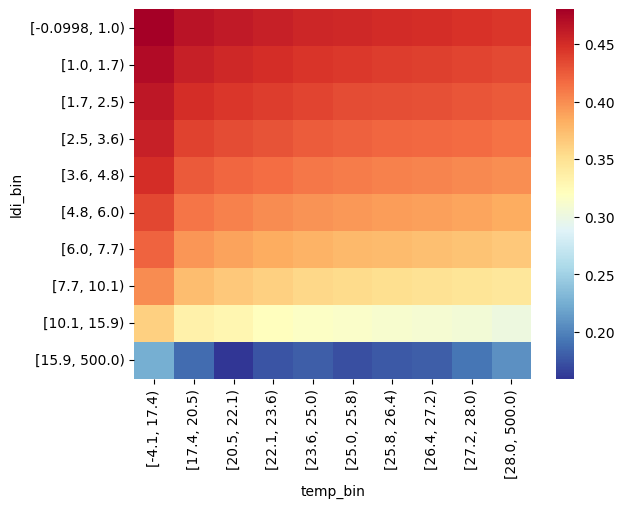

In [220]:
sns.heatmap(r.groupby(['ldi_bin', 'temp_bin']).pred_no_loc.mean().unstack(), cmap='RdYlBu_r')

<Axes: xlabel='temp_bin', ylabel='ldi_bin'>

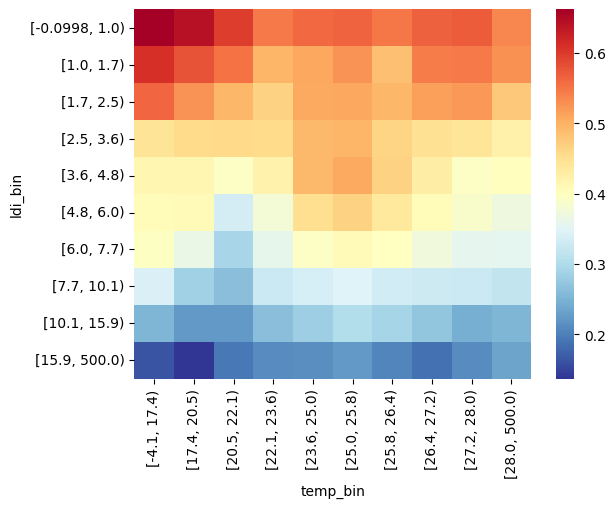

In [216]:
raw_df['ldi_bin'] = pd.cut(raw_df.ldi_pc_pd, sorted(df.ldi.unique()) + [500], right=False)
raw_df['temp_bin'] = pd.cut(raw_df.mean_temperature, sorted(df.temp.unique()) + [500], right=False)
sns.heatmap(raw_df.groupby(['ldi_bin', 'temp_bin']).stunting.mean().unstack(), cmap='RdYlBu_r')

In [181]:
c = x.groupby('ihme_loc_id').stunting.count()
c = c / c.sum()
pd.concat([c.rename('data_proportion'), model.ranef.loc[c.index]], axis=1).sort_values('data_proportion')

,data_proportion,X.Intercept.
ihme_loc_id,,
GIN,0.000580,-0.100010
GTM,0.000697,0.790271
HND,0.001509,-0.092971
PAK,0.001625,0.258798
ETH,0.005572,0.249092
KEN,0.006617,0.046343
CMR,0.015092,-0.152668
TGO,0.015556,-0.239569
KHM,0.020780,0.218250


In [156]:
cc = raw_df.groupby('ihme_loc_id').stunting.count()
cc = cc / cc.sum()
cc

ihme_loc_id
AGO    0.006862
ALB    0.003381
ARM    0.003180
BDI    0.009830
BEN    0.031896
BFA    0.027398
BOL    0.007577
CAF    0.004156
CIV    0.011430
CMR    0.009176
COD    0.011863
COL    0.015415
COM    0.002646
EGY    0.082557
ETH    0.008905
GAB    0.003974
GHA    0.015062
GIN    0.015304
GTM    0.012064
GUY    0.001479
HND    0.010736
HTI    0.019087
IND    0.230022
JOR    0.012255
KEN    0.011320
KGZ    0.009750
KHM    0.010847
LBR    0.009518
LSO    0.005021
MAR    0.005423
MDA    0.001358
MDG    0.011159
MLI    0.025577
MMR    0.008542
MOZ    0.010243
MWI    0.018574
NAM    0.011330
NER    0.005282
NGA    0.067364
NPL    0.015173
PAK    0.004015
PER    0.040036
RWA    0.011209
SEN    0.043024
SLE    0.007285
SWZ    0.002244
TCD    0.010927
TGO    0.005564
TJK    0.005262
TLS    0.012346
TZA    0.018977
UGA    0.021432
ZMB    0.017055
ZWE    0.017890
Name: stunting, dtype: float64

In [133]:
df = m.data


In [212]:
df['ldi'] = df['grid_cell'].apply(lambda s: s.split("_")[0].split(',')[0][1:]).astype(float)
df['temp'] = df['grid_cell'].apply(lambda s: s.split("_")[1].split(',')[0][1:]).astype(float)

<Axes: xlabel='mean_temperature', ylabel='fits'>

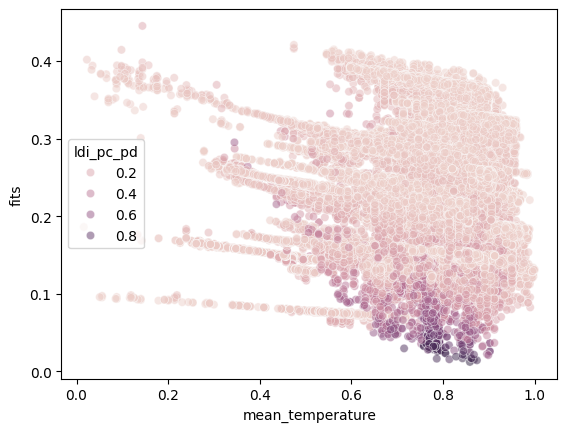

In [128]:
import matplotlib.pyplot as plt
sns.scatterplot(data=df, x='mean_temperature', y='fits', hue='ldi_pc_pd', alpha=0.5)



<Axes: xlabel='ldi_pc_pd', ylabel='residuals'>

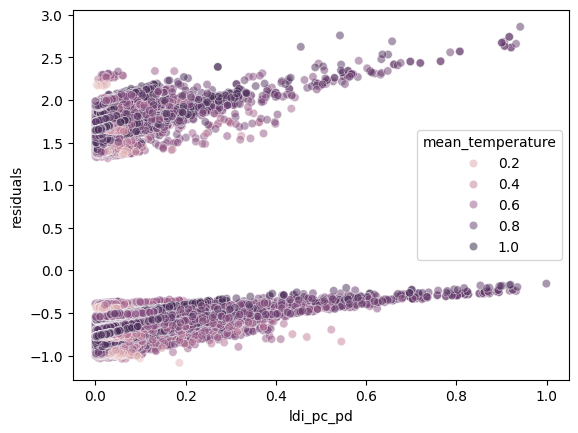

In [126]:
sns.scatterplot(data=df, x='ldi_pc_pd', y='residuals', hue='mean_temperature', alpha=0.5)

In [119]:
df

,intercept,mean_temperature,ldi_pc_pd,ihme_loc_id,stunting,residuals,fits
14,1.0,0.788346,0.027204,BDI,0.0,-0.942019,0.358342
19,1.0,0.788346,0.024913,BDI,0.0,-0.944607,0.359907
32,1.0,0.803997,0.003160,BDI,1.0,1.403802,0.373316
36,1.0,0.803997,0.003721,BDI,1.0,1.404576,0.372911
46,1.0,0.788346,0.005552,BDI,1.0,1.403937,0.373245
...,...,...,...,...,...,...,...
959368,1.0,0.896460,0.015889,KHM,0.0,-0.754460,0.247688
959370,1.0,0.879846,0.002393,KHM,0.0,-0.773853,0.258755
959383,1.0,0.899109,0.012741,KHM,0.0,-0.757960,0.249677
959395,1.0,0.904647,0.093836,KHM,0.0,-0.658827,0.195091


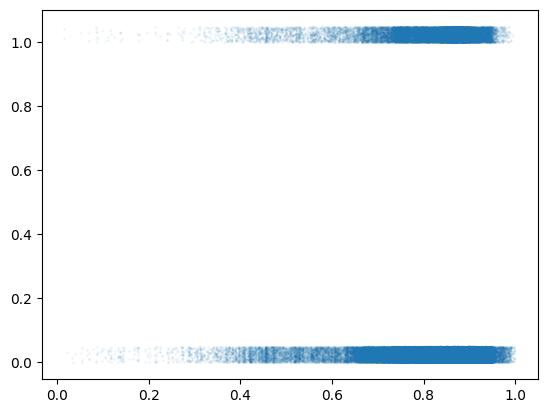

In [115]:
plt.scatter(df.mean_temperature, df.stunting + 0.05 * np.random.random(len(df)), alpha=0.05, s=1)

<Axes: xlabel='temp', ylabel='ldi'>

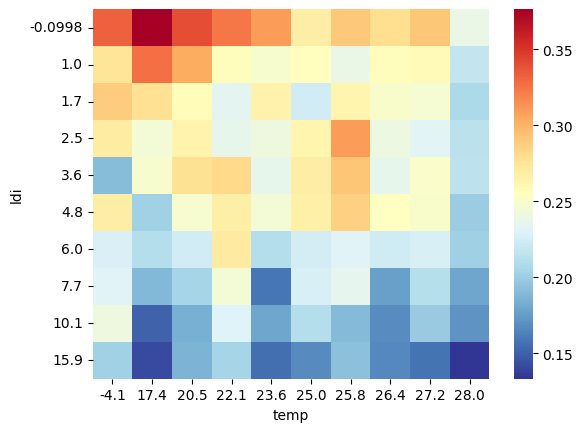

In [140]:
sns.heatmap(df.groupby(['ldi', 'temp']).stunting.mean().unstack().sort_index(), cmap='RdYlBu_r')

<Axes: xlabel='temp', ylabel='ldi'>

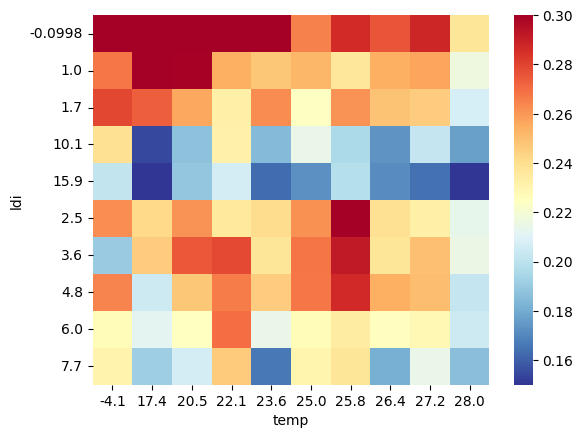

In [137]:
sns.heatmap(df.groupby(['ldi', 'temp']).fits.mean().unstack(), cmap='RdYlBu_r', vmax=0.3, vmin=0.15)

In [91]:
df.grid_cell.unique()

array(['(4.8, 6.0]_(23.6, 25.0]', '(3.6, 4.8]_(23.6, 25.0]',
       '(-0.0998, 1.0]_(20.5, 22.1]', '(-0.0998, 1.0]_(22.1, 23.6]',
       '(1.0, 1.7]_(23.6, 25.0]', '(-0.0998, 1.0]_(23.6, 25.0]',
       '(-0.0998, 1.0]_(25.0, 25.8]', '(1.0, 1.7]_(25.0, 25.8]',
       '(-0.0998, 1.0]_(17.4, 20.5]', '(1.0, 1.7]_(22.1, 23.6]',
       '(1.0, 1.7]_(17.4, 20.5]', '(4.8, 6.0]_(20.5, 22.1]',
       '(2.5, 3.6]_(17.4, 20.5]', '(1.7, 2.5]_(22.1, 23.6]',
       '(1.0, 1.7]_(-4.1, 17.4]', '(1.7, 2.5]_(23.6, 25.0]',
       '(2.5, 3.6]_(23.6, 25.0]', '(1.7, 2.5]_(17.4, 20.5]',
       '(1.0, 1.7]_(20.5, 22.1]', '(6.0, 7.7]_(20.5, 22.1]',
       '(4.8, 6.0]_(17.4, 20.5]', '(1.7, 2.5]_(20.5, 22.1]',
       '(3.6, 4.8]_(20.5, 22.1]', '(6.0, 7.7]_(17.4, 20.5]',
       '(1.7, 2.5]_(-4.1, 17.4]', '(3.6, 4.8]_(17.4, 20.5]',
       '(1.7, 2.5]_(25.0, 25.8]', '(3.6, 4.8]_(25.0, 25.8]',
       '(6.0, 7.7]_(25.0, 25.8]', '(7.7, 10.1]_(25.0, 25.8]',
       '(4.8, 6.0]_(25.0, 25.8]', '(2.5, 3.6]_(25.0, 25.8]',
   

In [90]:
rdf = raw_df.combine_first(model.data)



,fits,ihme_loc_id,intercept,ldi_pc_pd,mean_temperature,residuals,stunting
0,0.358342,BDI,1.0,4.886422,22.43,-0.942019,0.0
1,0.359907,BDI,1.0,4.474900,22.43,-0.944607,0.0
2,0.373316,BDI,1.0,0.567747,23.08,1.403802,1.0
3,0.372911,BDI,1.0,0.668471,23.08,1.404576,1.0
4,0.373245,BDI,1.0,0.997473,22.43,1.403937,1.0
...,...,...,...,...,...,...,...
99381,0.247688,KHM,1.0,2.854133,26.92,-0.754460,0.0
99382,0.258755,KHM,1.0,0.430112,26.23,-0.773853,0.0
99383,0.249677,KHM,1.0,2.288677,27.03,-0.757960,0.0
99384,0.195091,KHM,1.0,16.854518,27.26,-0.658827,0.0


In [89]:
model.data

,intercept,mean_temperature,ldi_pc_pd,ihme_loc_id,stunting,residuals,fits
0,1.0,0.788346,0.027204,BDI,0.0,-0.942019,0.358342
1,1.0,0.788346,0.024913,BDI,0.0,-0.944607,0.359907
2,1.0,0.803997,0.003160,BDI,1.0,1.403802,0.373316
3,1.0,0.803997,0.003721,BDI,1.0,1.404576,0.372911
4,1.0,0.788346,0.005552,BDI,1.0,1.403937,0.373245
...,...,...,...,...,...,...,...
99381,1.0,0.896460,0.015889,KHM,0.0,-0.754460,0.247688
99382,1.0,0.879846,0.002393,KHM,0.0,-0.773853,0.258755
99383,1.0,0.899109,0.012741,KHM,0.0,-0.757960,0.249677
99384,1.0,0.904647,0.093836,KHM,0.0,-0.658827,0.195091


In [46]:
fit = m.predict(df, verify_predictions=False)

In [53]:
df['pred'] = (df['fits'] > 0.5).astype(int)

<Axes: >

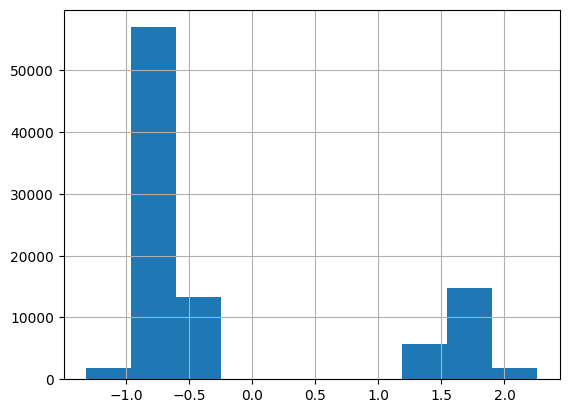

In [61]:
df['residuals'].hist()

<Axes: >

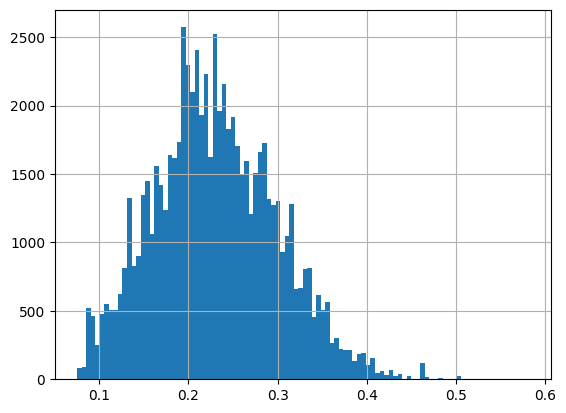

In [62]:
df[df.stunting == 0].fits.hist(bins=100)

<Axes: >

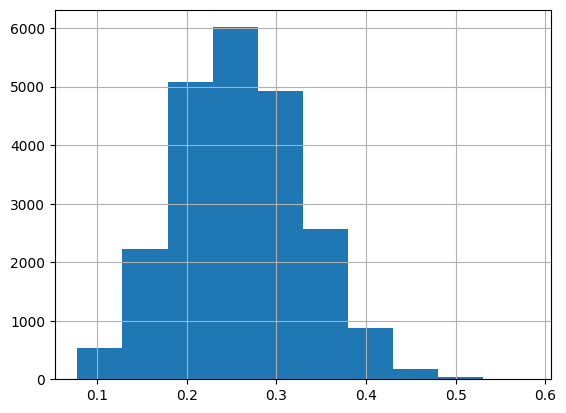

In [43]:
df[df.stunting == 1].fits.hist()

<Axes: >

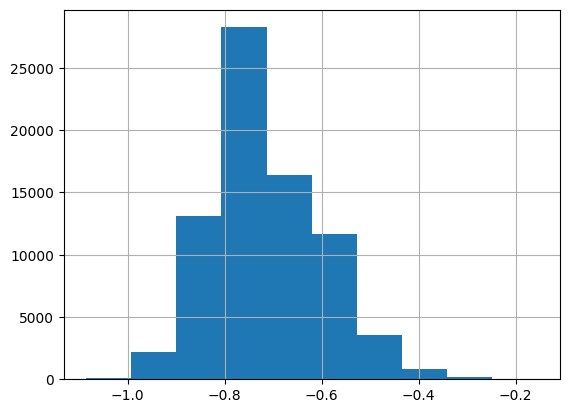

In [31]:
df = model.data 
df[df.stunting == 0].residuals.hist()

<Axes: >

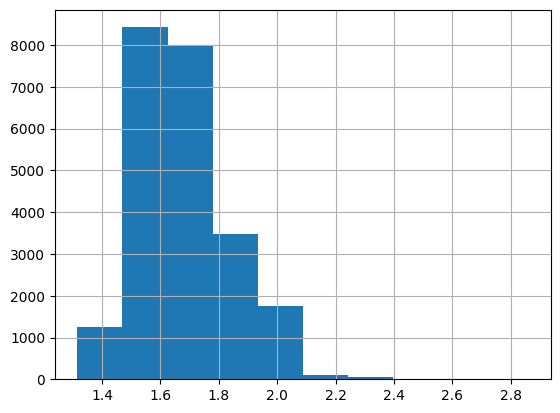

In [32]:
df[df.stunting == 1].residuals.hist()

In [ ]:
import numpy as np
size = 5000
x = pd.DataFrame({
    'temp': np.linspace(5, 50, size),
    'ldi_pc_pd': np.linspace(0, 500, size),
    'ihme_loc_id': np.nan * np.ones(size),
    'intercept': np.ones(size),
})

for predictor in model_spec.predictors:
    x, _ = scaling.scale_column(x, predictor.name, predictor.transform, var_info[predictor.name])



In [ ]:
x

In [ ]:
model.predict(x, skip_data_checks=True, verify_predictions=False)

In [ ]:
var_info

In [184]:
raw_df[(raw_df.ldi_pc_pd < 0.95) & (raw_df.mean_temperature < 17.56)].stunting.mean()

0.35310344827586204